# Carbon Footprint Eval

In [13]:
import pandas as pd
import gzip
import json
from tqdm import tqdm
from statistics import mean

RETRIEVAL_PARADIGMS = {
    'multi-qa-distilbert-cos-v1': 'Bi-Encoder',
    'DPH': 'Lexical',
    'multi-qa-minilm-l6-cos-v1': 'Bi-Encoder',
    'IFB2': 'Lexical',
    'InB2': 'Lexical',
    'msmarco-minilm-l12-cos-v5': 'Bi-Encoder',
    'PL2': 'Lexical',
    'BM25': 'Lexical',
    'hltcoe-plaidx-large-eng-tdist-mt5xxl-engeng': 'Late Interaction',
    'DirichletLM': 'Lexical',
    'colbert-ir-colbertv2.0': 'Late Interaction',
    'multi-qa-mpnet-base-cos-v1': 'Bi-Encoder',
    'sentence-transformers-msmarco-roberta-base-ance-firstp': 'Bi-Encoder',
    'TF_IDF': 'Lexical',
    'DFIZ': 'Lexical',
    'msmarco-minilm-l6-cos-v5': 'Bi-Encoder',
    'DLH': 'Lexical',
    'msmarco-distilbert-base-tas-b': 'Bi-Encoder',
    'colbert-ir-colbertv1.9': 'Late Interaction',
    'Hiemstra_LM': 'Lexical',
    'msmarco-distilbert-base-v3': 'Bi-Encoder',
}

def dataset_id_to_corpus_sizes():
    ret = {}
    for dataset in tqdm(["msmarco-passage/trec-dl-2019/judged", "msmarco-passage/trec-dl-2020/judged", "disks45/nocr/trec-robust-2004", "clueweb09/en/trec-web-2012", "clueweb12/trec-web-2014"]):
        ret[dataset] = {}
        with gzip.open(f'../data/processed/sampled-corpora/{dataset.replace("/", "-")}.json.gz') as f:
            f = json.load(f)
            for group in f.keys():
                for sampling in f[group].keys():
                    if sampling not in ret[dataset]:
                        ret[dataset][sampling] = set()

                    ret[dataset][sampling].update(f[group][sampling])
            
            ret[dataset] = {k: len(v) for k, v in ret[dataset].items()}

    return ret

def to_rows(df):
    ret = []
    for sampling in df.keys():
        row = {'Sampling': sampling}
        for paradigm in df[sampling].keys():
            for dataset in df[sampling][paradigm].keys():
                row[f'{paradigm} ({dataset})'] = mean(df[sampling][paradigm][dataset])
        ret += [row]
    return pd.DataFrame(ret)

def parse_data(file_name, target_maeasure):
    raw_data = pd.read_json(file_name, lines=True)
    df = {}
    for _, i in raw_data.iterrows():
        if i['sampling'] not in df:
            df[i['sampling']] = {}
        paradigm = RETRIEVAL_PARADIGMS[i['approach']]
        if paradigm not in df[i['sampling']]:
            df[i['sampling']][paradigm] = {}
        dataset = i['dataset'].split('/')[0]

        if dataset not in df[i['sampling']][paradigm]:
            df[i['sampling']][paradigm][dataset] = []
        df[i['sampling']][paradigm][dataset] += [target_maeasure(i)]

    return df


In [15]:
df_recall = parse_data('../data/processed/carbon-footprints/aggregated.jsonl', lambda i: i['RBO@10'])
df_recall = to_rows(df_recall)
df_recall

,Sampling,Bi-Encoder (disks45),Bi-Encoder (msmarco-passage),Bi-Encoder (clueweb12),Lexical (disks45),Lexical (msmarco-passage),Lexical (clueweb12),Late Interaction (disks45),Late Interaction (msmarco-passage),Late Interaction (clueweb12)
0,loft-10000,0.430582,0.777053,0.185293,0.495045,0.601278,0.308278,0.458577,0.693346,0.167383
1,top-50-run-pool,0.887722,0.973021,0.506561,0.927411,0.913812,0.750409,0.754609,0.781305,0.441312
2,top-100-run-pool,0.935559,0.981391,0.612200,0.945771,0.932586,0.790978,0.759279,0.787349,0.525283
3,re-rank-top-1000-bm25,0.921313,0.889607,0.145941,0.962693,0.857389,0.083680,0.758149,0.748674,0.159084
4,top-1000-run-pool,0.999431,0.999977,0.988980,0.999852,0.998947,0.987769,0.993083,0.991116,0.973369
5,top-25-run-pool,0.823914,0.953636,0.407552,0.910328,0.900988,0.684868,0.726224,0.760698,0.359531
6,loft-1000,0.113500,0.679540,0.114994,0.138044,0.513257,0.176107,0.129638,0.634496,0.102789
7,top-10-run-pool,0.712174,0.907674,0.289247,0.884659,0.879525,0.605693,0.682015,0.755484,0.256743


In [3]:
dataset_sizes = dataset_id_to_corpus_sizes()

def to_emission_rows(df):
    ret = []
    for sampling in df.keys():
        for paradigm in df[sampling].keys():
            for dataset in df[sampling][paradigm].keys():
                for tmp in df[sampling][paradigm][dataset]:
                    ret += [{'Paradigm': paradigm, 'Size': tmp['Size'], 'Emissions': tmp['Emissions'],'Dataset': dataset}]
    return pd.DataFrame(ret)

100%|██████████| 5/5 [00:26<00:00,  5.33s/it]


In [4]:
#df_emissions = parse_data('../data/processed/carbon-footprints/aggregated.jsonl', lambda i: {'Emissions': i['aggregated']['emissions'], 'Size': dataset_sizes[i['dataset']][i['sampling']]})
df_emissions = parse_data('../data/processed/carbon-footprints/aggregated.jsonl', lambda i: {'Emissions': i['aggregated']['energy_consumed'], 'Size': dataset_sizes[i['dataset']][i['sampling']]})

df_emissions = to_emission_rows(df_emissions)

In [5]:
CORPUS_SIZES = {
    'clueweb09': 1040859705,
    'clueweb12': 733019372,
    'msmarco-passage': 8841823,
    'disks45': 528155
}

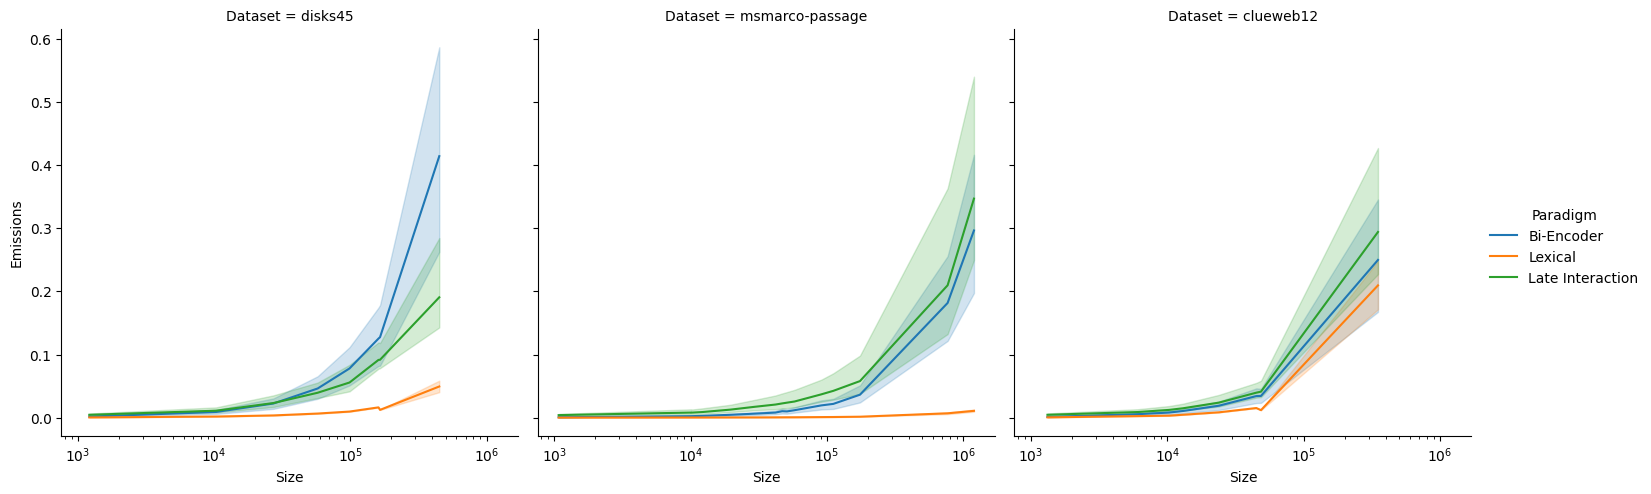

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.relplot(data=df_emissions, kind='line', x='Size', y='Emissions', col='Dataset', hue='Paradigm')
plt.xscale('log')

In [7]:
observed_emissions = parse_data('../data/processed/carbon-footprints/aggregated.jsonl', lambda i: {'Emissions': i['aggregated']['energy_consumed'], 'Size': dataset_sizes[i['dataset']][i['sampling']]})

In [8]:
aggregated_observed_emissions = {}

for dataset_type in observed_emissions.keys():
    for paradigm in observed_emissions[dataset_type].keys():
        for dataset in observed_emissions[dataset_type][paradigm].keys():
            if paradigm not in aggregated_observed_emissions:
                aggregated_observed_emissions[paradigm] = {}
            if dataset not in aggregated_observed_emissions[paradigm]:
                aggregated_observed_emissions[paradigm][dataset] = {'Emissions': 0, 'Size': 0}
            for i in observed_emissions[dataset_type][paradigm][dataset]:
                aggregated_observed_emissions[paradigm][dataset]['Emissions'] += i['Emissions']
                aggregated_observed_emissions[paradigm][dataset]['Size'] += i['Size']
                aggregated_observed_emissions[paradigm][dataset]['EmissionsPerDocument'] = aggregated_observed_emissions[paradigm][dataset]['Emissions'] / aggregated_observed_emissions[paradigm][dataset]['Size']


In [11]:
df_predicted_observations = []

for i in [1000000, 10000000, 100000000, 1000000000]:
    for dataset in ['disks45', 'msmarco-passage', 'clueweb12']:
        for paradigm in ['Bi-Encoder', 'Lexical', 'Late Interaction']:
            size = min(i, CORPUS_SIZES[dataset])
            emissions = size*aggregated_observed_emissions[paradigm][dataset]['EmissionsPerDocument']
            df_predicted_observations += [{'Paradigm': paradigm, 'Size': size, 'Emissions': emissions, 'Dataset': dataset}]

df_predicted_observations = pd.DataFrame(df_predicted_observations)

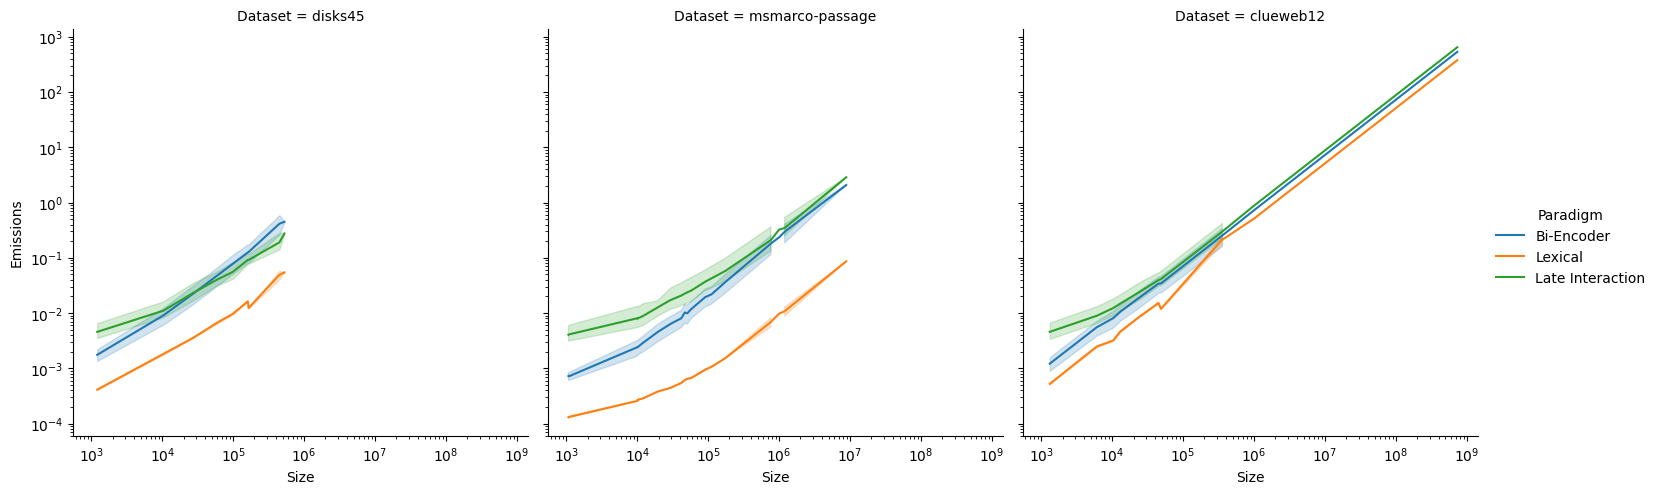

In [12]:
sns.relplot(data=pd.concat([df_emissions, df_predicted_observations]), kind='line', x='Size', y='Emissions', col='Dataset', hue='Paradigm')
plt.xscale('log')
plt.yscale('log')